In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

In [2]:
data = pd.read_csv("cleaned_csv.csv")

In [3]:
data.sample(5)

,text,label
2679,первый определиться онлайн офлайн магазин онла...,True
3064,летний юбилей чёрный квадрат малевич третьяков...,False
3825,межпланетный зонд джуно продолжать исследовать...,False
2489,отгонять мысль пенсия ассоциироваться безрадос...,True
1669,протоиерей всеволод чаплин освободить должност...,False


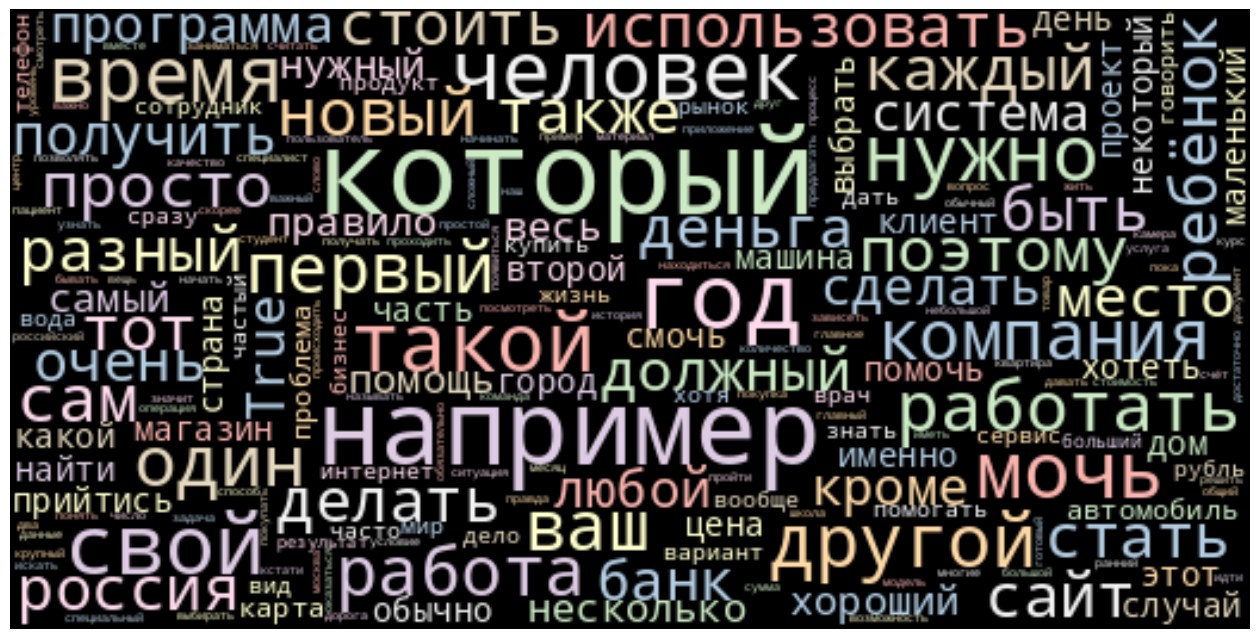

In [4]:
ads_texts = WordCloud(width =520, height =260, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(data[data["label"] == True].to_string())
plt.figure(figsize=(16,10))
plt.imshow(ads_texts, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

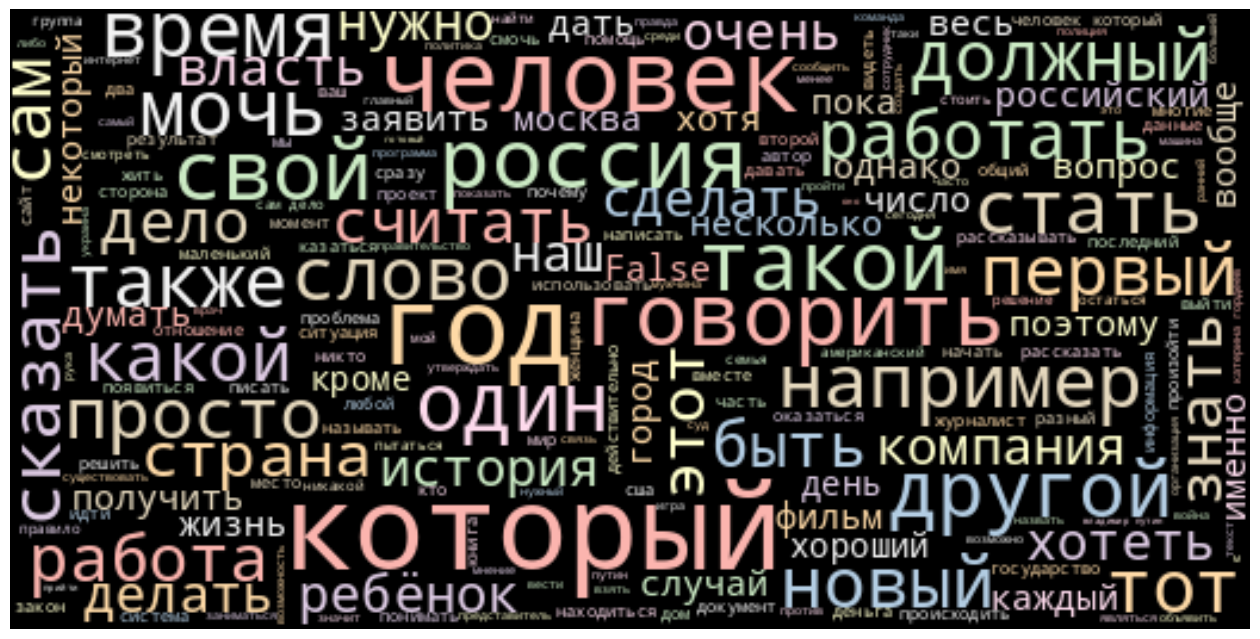

In [5]:
news_texts = WordCloud(width =520, height =260, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(data[data["label"] == False].to_string())
plt.figure(figsize=(16,10))
plt.imshow(news_texts, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data['text'].values, data["label"].values, test_size=0.2, random_state=434)

In [7]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

In [8]:
tokenizer.train_from_iterator(
    x_train,
    vocab_size=5_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

In [9]:
class TextDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels
        self.max_len = max_len


    def __len__(self):
        return len(self.tokens)


    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(int(label))
        tokens = self.tokens[idx]
        out = torch.zeros(self.max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:self.max_len]
        return out, label

In [10]:
train_tokens = [tokenizer.encode(str(text)).ids for text in list(x_train)]
test_tokens = [tokenizer.encode(str(text)).ids for text in list(x_test)]

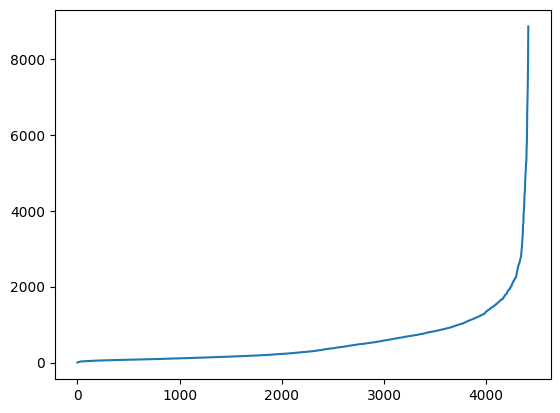

In [11]:
plt.plot(sorted([len(arr) for arr in train_tokens]))

In [12]:
BATCH_SIZE = 32
max_len = 1000

train_dataset = TextDataset(train_tokens, y_train, 1000)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TextDataset(test_tokens, y_test, 1000)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
class LSTM_classifier(nn.Module):
    def __init__(self, hidden_dim=128, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.3, n_classes=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
        return out

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [16]:
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='binary')
    return score, predicted

In [17]:
def train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=20):
    best_score = 0
    for epoch in tqdm(range(epochs)):
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            loss = loss_function(predict, labels)
            loss.backward()
            optimizer.step()
        score, _ = eval_nn(model, test_loader)
        print(epoch, 'valid:', score)
        if score > best_score:
            torch.save(model.state_dict(), 'lstm.pt')
            best_score = score
    return best_score

In [18]:
model = LSTM_classifier(hidden_dim=256, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.1)   

In [19]:
model.apply(init_weights)
model.to(device)

LSTM_classifier(
  (embedding_layer): Embedding(5000, 300)
  (lstm_layer): LSTM(300, 256, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (fc_layer): Linear(in_features=512, out_features=128, bias=True)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
)

In [20]:
optimizer = optim.AdamW(model.parameters())

In [21]:
loss_function = nn.CrossEntropyLoss().to(device)

In [22]:
train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 10%|█         | 1/10 [03:28<31:14, 208.23s/it]

0 valid: 0.2754098360655738


 20%|██        | 2/10 [06:59<28:01, 210.22s/it]

1 valid: 0.4940239043824701


 30%|███       | 3/10 [10:40<25:04, 214.88s/it]

2 valid: 0.5627118644067797


 40%|████      | 4/10 [14:12<21:23, 213.88s/it]

3 valid: 0.5745454545454546


 50%|█████     | 5/10 [17:41<17:41, 212.24s/it]

4 valid: 0.5653710247349824


 60%|██████    | 6/10 [21:11<14:05, 211.28s/it]

5 valid: 0.5882352941176471


 70%|███████   | 7/10 [24:46<10:37, 212.54s/it]

6 valid: 0.6046511627906976


 80%|████████  | 8/10 [28:24<07:08, 214.30s/it]

7 valid: 0.5815602836879432


 90%|█████████ | 9/10 [32:07<03:36, 216.88s/it]

8 valid: 0.6143790849673203


100%|██████████| 10/10 [35:42<00:00, 214.30s/it]

9 valid: 0.5838926174496645


0.6143790849673203

In [23]:
model = LSTM_classifier(hidden_dim=256, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.1)
model.load_state_dict(torch.load('lstm.pt'));

In [24]:
_, preds = eval_nn(model, test_loader)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.92      0.95      0.94       937
        True       0.68      0.56      0.61       167

    accuracy                           0.89      1104
   macro avg       0.80      0.76      0.78      1104
weighted avg       0.89      0.89      0.89      1104

